In [3]:
import numpy as np

def get_next_state(pattern: str, current_len: int, next_char: str) -> int:
    """
    计算在给定当前匹配长度和下一个字符时，马尔可夫链的下一个状态。

    Args:
        pattern (str): 目标模式，例如 "HTH"。
        current_len (int): 当前已匹配的模式前缀的长度（即当前状态）。
        next_char (str): 下一次投掷的实际结果 ('H' 或 'T')。

    Returns:
        int: 转移后的新状态（即新的匹配长度）。
    """
    # 构造当前匹配序列加上新字符后的完整序列
    sequence = pattern[:current_len] + next_char

    # 从最长的可能性开始，寻找新序列的后缀与模式前缀的最长匹配
    # 这是马尔可夫链状态转移的核心逻辑
    for length in range(len(sequence), 0, -1):
        suffix = sequence[-length:]
        prefix = pattern[:length]
        if suffix == prefix:
            return length  # 返回最长的匹配长度作为新状态

    return 0  # 如果没有任何匹配，回到初始状态 0

def calculate_expected_flips_markov(pattern: str, p_heads: float) -> float:
    """
    使用吸收马尔可夫链模型计算首次出现特定模式的期望投掷次数。

    Args:
        pattern (str): 由 'H' 和 'T' 组成的目标模式。
        p_heads (float): 掷出正面 (H) 的概率。

    Returns:
        float: 首次出现该模式的期望投掷次数。
    """
    L = len(pattern)
    if L == 0:
        return 0.0

    p_tails = 1.0 - p_heads
    
    # 我们要求解 E_0, E_1, ..., E_{L-1} 这 L 个变量。
    # 吸收状态 E_L = 0。
    # 方程组形式为 A * x = b，其中 x 是 [E_0, E_1, ..., E_{L-1}]^T
    n_states = L
    A = np.zeros((n_states, n_states))
    b = np.ones(n_states)

    # 遍历每个状态 i (从 0 到 L-1)，为 E_i 建立一个方程
    for i in range(n_states):
        # 方程 E_i = 1 + p * E_{next_H} + q * E_{next_T}
        # 整理为标准形式: E_i - p*E_{next_H} - q*E_{next_T} = 1
        
        # 1. 设置 E_i 的系数
        A[i, i] = 1.0

        # 2. 计算掷出 H 后的转移
        next_state_H = get_next_state(pattern, i, 'H')
        if next_state_H < L:  # 如果不是吸收状态
            A[i, next_state_H] -= p_heads

        # 3. 计算掷出 T 后的转移
        next_state_T = get_next_state(pattern, i, 'T')
        if next_state_T < L:  # 如果不是吸收状态
            A[i, next_state_T] -= p_tails
            
    # 使用 numpy 求解线性方程组 A * x = b
    try:
        expected_values = np.linalg.solve(A, b)
    except np.linalg.LinAlgError:
        return float('inf') # 如果矩阵是奇异的，则无法求解

    # 我们要求的是从状态 0 开始的期望次数 E_0
    return expected_values[0]

### 程序使用示例


if __name__ == "__main__":
    # 设定硬币的概率
    # 为了演示，我们假设是一个均匀硬币，p=0.5
    # 你可以修改为任意 0 < p < 1 的值
    p_h = 0.6
    print(f"设定硬币掷出正面的概率 p = {p_h}\n")

    # 定义三个模式
    patterns = [
        "HHHHHHTTTTTT", # 1. 几乎不重叠
        "HHHHHHHHHHHH", # 2. 高度重叠
        "HTHTHTTHTHT"   # 3. 复杂重叠
    ]

    for p_str in patterns:
        print(f"--- 正在计算模式: {p_str} ---")
        
        # 使用马尔可夫链方法计算
        expected_flips = calculate_expected_flips_markov(p_str, p_h)
        
        print(f"期望投掷次数为: {expected_flips:.2f}")
        
        # 为了对比，我们也可以用鞅方法的公式直接计算来验证
        # (这部分仅为验证，核心是上面的马尔可夫方法)
        martingale_result = 0
        p_t = 1.0 - p_h
        for k in range(1, len(p_str) + 1):
            prefix = p_str[:k]
            suffix = p_str[-k:]
            if prefix == suffix:
                prob_prefix = 1.0
                for char in prefix:
                    prob_prefix *= p_h if char == 'H' else p_t
                martingale_result += 1 / prob_prefix
        
        print(f"（使用鞅方法验证结果: {martingale_result:.2f}）")
        print("-" * 30 + "\n")

    # 你也可以测试一个更短的、更有趣的模式
    print("--- 正在计算模式: HTHT ---")
    expected_flips_ht_ht = calculate_expected_flips_markov("HTHT", 0.5)
    print(f"期望投掷次数为: {expected_flips_ht_ht:.2f}")
    print("-" * 30 + "\n")

设定硬币掷出正面的概率 p = 0.6

--- 正在计算模式: HHHHHHTTTTTT ---
期望投掷次数为: 5232.78
（使用鞅方法验证结果: 5232.78）
------------------------------

--- 正在计算模式: HHHHHHHHHHHH ---
期望投掷次数为: 1145.98
（使用鞅方法验证结果: 1145.98）
------------------------------

--- 正在计算模式: HTHTHTTHTHT ---
期望投掷次数为: 3161.20
（使用鞅方法验证结果: 3161.20）
------------------------------

--- 正在计算模式: HTHT ---
期望投掷次数为: 20.00
------------------------------



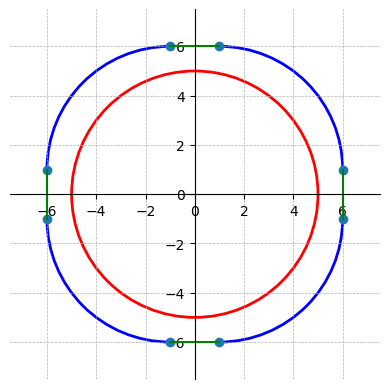

In [35]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# 创建一个图形和坐标轴
fig, ax = plt.subplots()

# 设置坐标轴范围从0到10
ax.set_xlim(-7.5, 7.5)
ax.set_ylim(-7.5, 7.5)

# 设置坐标轴在原点(0,0)处相交
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

# 添加坐标轴标签
#ax.set_xlabel('X-axis', loc='right')
#ax.set_ylabel('Y-axis', loc='top')

# 添加网格线以方便观察
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# 在这里添加你的点。例如，要添加一个点 (5, 5)，你可以使用：
# ax.plot(5, 5, marker='o', label='Point at (5, 5)')
# 如果有多个点，你可以使用列表：
x_values = [-1, 1, -6,-6,6,6,-1,1]
y_values = [6, 6, 1,-1,1,-1,-6,-6]
ax.plot(x_values, y_values, marker='o', linestyle='None', label='My Points')
plt.plot([-1, 1], [6, 6], '-',color='g')
plt.plot([-1, 1], [-6, -6], '-',color='g')
plt.plot([-6,-6], [1,-1], '-',color='g')
plt.plot([6,6], [1,-1], '-',color='g')
arc = patches.Arc((-1, 1), 10, 10, angle=0, theta1=90, theta2=180, color='blue', linewidth=2)
ax.add_patch(arc,)
arc = patches.Arc((1, 1), 10, 10, angle=0, theta1=0, theta2=90, color='blue', linewidth=2)
ax.add_patch(arc)
arc = patches.Arc((1, -1), 10, 10, angle=0, theta1=270, theta2=360, color='blue', linewidth=2)
ax.add_patch(arc)
arc = patches.Arc((-1, -1), 10, 10, angle=0, theta1=180, theta2=270, color='blue', linewidth=2)
ax.add_patch(arc)
# 将长宽比设置为相等，以确保X轴和Y轴的比例相同
ax.set_aspect('equal', adjustable='box')

# 如果添加了点，取消注释下一行以显示图例
# ax.legend()
circle = patches.Circle((0, 0), 5, edgecolor='r', facecolor='none', linewidth=2)
ax.add_patch(circle)
# 保存图表
plt.savefig('coordinate_plane.png')

In [ ]:
import numpy as np

def get_next_state(pattern: str, current_len: int, next_char: str) -> int:
    """
    计算在给定当前匹配长度和下一个字符时，马尔可夫链的下一个状态。

    Args:
        pattern (str): 目标模式，例如 "HTH"。
        current_len (int): 当前已匹配的模式前缀的长度（即当前状态）。
        next_char (str): 下一次投掷的实际结果 ('H' 或 'T')。

    Returns:
        int: 转移后的新状态（即新的匹配长度）。
    """
    # 构造当前匹配序列加上新字符后的完整序列
    sequence = pattern[:current_len] + next_char

    # 从最长的可能性开始，寻找新序列的后缀与模式前缀的最长匹配
    # 这是马尔可夫链状态转移的核心逻辑
    for length in range(len(sequence), 0, -1):
        suffix = sequence[-length:]
        prefix = pattern[:length]
        if suffix == prefix:
            return length  # 返回最长的匹配长度作为新状态

    return 0  # 如果没有任何匹配，回到初始状态 0

def calculate_expected_flips_markov(pattern: str, p_heads: float) -> float:
    """
    使用吸收马尔可夫链模型计算首次出现特定模式的期望投掷次数。

    Args:
        pattern (str): 由 'H' 和 'T' 组成的目标模式。
        p_heads (float): 掷出正面 (H) 的概率。

    Returns:
        float: 首次出现该模式的期望投掷次数。
    """
    L = len(pattern)
    if L == 0:
        return 0.0

    p_tails = 1.0 - p_heads
    
    # 我们要求解 E_0, E_1, ..., E_{L-1} 这 L 个变量。
    # 吸收状态 E_L = 0。
    # 方程组形式为 A * x = b，其中 x 是 [E_0, E_1, ..., E_{L-1}]^T
    n_states = L
    A = np.zeros((n_states, n_states))
    b = np.ones(n_states)

    # 遍历每个状态 i (从 0 到 L-1)，为 E_i 建立一个方程
    for i in range(n_states):
        # 方程 E_i = 1 + p * E_{next_H} + q * E_{next_T}
        # 整理为标准形式: E_i - p*E_{next_H} - q*E_{next_T} = 1
        
        # 1. 设置 E_i 的系数
        A[i, i] = 1.0

        # 2. 计算掷出 H 后的转移
        next_state_H = get_next_state(pattern, i, 'H')
        if next_state_H < L:  # 如果不是吸收状态
            A[i, next_state_H] -= p_heads

        # 3. 计算掷出 T 后的转移
        next_state_T = get_next_state(pattern, i, 'T')
        if next_state_T < L:  # 如果不是吸收状态
            A[i, next_state_T] -= p_tails
            
    # 使用 numpy 求解线性方程组 A * x = b
    try:
        expected_values = np.linalg.solve(A, b)
    except np.linalg.LinAlgError:
        return float('inf') # 如果矩阵是奇异的，则无法求解

    # 我们要求的是从状态 0 开始的期望次数 E_0
    return expected_values[0]

### 程序使用示例


if __name__ == "__main__":
    # 设定硬币的概率
    # 为了演示，我们假设是一个均匀硬币，p=0.5
    # 你可以修改为任意 0 < p < 1 的值
    p_h = 0.6
    print(f"设定硬币掷出正面的概率 p = {p_h}\n")

    # 定义三个模式
    patterns = [
        "HHHHHHTTTTTT", # 1. 几乎不重叠
        "HHHHHHHHHHHH", # 2. 高度重叠
        "HTHTHTTHTHT"   # 3. 复杂重叠
    ]

    for p_str in patterns:
        print(f"--- 正在计算模式: {p_str} ---")
        
        # 使用马尔可夫链方法计算
        expected_flips = calculate_expected_flips_markov(p_str, p_h)
        
        print(f"期望投掷次数为: {expected_flips:.2f}")
        
        # 为了对比，我们也可以用鞅方法的公式直接计算来验证
        # (这部分仅为验证，核心是上面的马尔可夫方法)
        martingale_result = 0
        p_t = 1.0 - p_h
        for k in range(1, len(p_str) + 1):
            prefix = p_str[:k]
            suffix = p_str[-k:]
            if prefix == suffix:
                prob_prefix = 1.0
                for char in prefix:
                    prob_prefix *= p_h if char == 'H' else p_t
                martingale_result += 1 / prob_prefix
        
        print(f"（使用鞅方法验证结果: {martingale_result:.2f}）")
        print("-" * 30 + "\n")

    # 你也可以测试一个更短的、更有趣的模式
    print("--- 正在计算模式: HTHT ---")
    expected_flips_ht_ht = calculate_expected_flips_markov("HTHT", 0.5)
    print(f"期望投掷次数为: {expected_flips_ht_ht:.2f}")
    print("-" * 30 + "\n")

设定硬币掷出正面的概率 p = 0.6

--- 正在计算模式: HHHHHHTTTTTT ---
期望投掷次数为: 5232.78
（使用鞅方法验证结果: 5232.78）
------------------------------

--- 正在计算模式: HHHHHHHHHHHH ---
期望投掷次数为: 1145.98
（使用鞅方法验证结果: 1145.98）
------------------------------

--- 正在计算模式: HTHTHTTHTHT ---
期望投掷次数为: 3161.20
（使用鞅方法验证结果: 3161.20）
------------------------------

--- 正在计算模式: HTHT ---
期望投掷次数为: 20.00
------------------------------



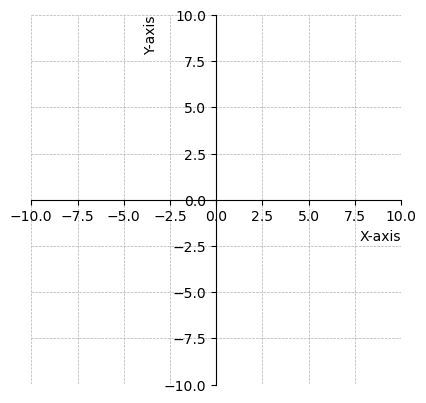

In [ ]:
import matplotlib.pyplot as plt

# 创建一个图形和坐标轴
fig, ax = plt.subplots()

# 设置坐标轴范围从0到10
ax.set_xlim(-7.5, 7.5)
ax.set_ylim(-7.5, 7.5)

# 设置坐标轴在原点(0,0)处相交
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

# 添加坐标轴标签
ax.set_xlabel('X-axis', loc='right')
ax.set_ylabel('Y-axis', loc='top')

# 添加网格线以方便观察
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# 在这里添加你的点。例如，要添加一个点 (5, 5)，你可以使用：
# ax.plot(5, 5, marker='o', label='Point at (5, 5)')
# 如果有多个点，你可以使用列表：
# x_values = [1, 2, 8]
# y_values = [3, 7, 5]
# ax.plot(x_values, y_values, marker='o', linestyle='None', label='My Points')

# 将长宽比设置为相等，以确保X轴和Y轴的比例相同
ax.set_aspect('equal', adjustable='box')

# 如果添加了点，取消注释下一行以显示图例
# ax.legend()

# 保存图表
plt.savefig('coordinate_plane.png')

In [ ]:
import numpy as np

def get_next_state(pattern: str, current_len: int, next_char: str) -> int:
    """
    计算在给定当前匹配长度和下一个字符时，马尔可夫链的下一个状态。

    Args:
        pattern (str): 目标模式，例如 "HTH"。
        current_len (int): 当前已匹配的模式前缀的长度（即当前状态）。
        next_char (str): 下一次投掷的实际结果 ('H' 或 'T')。

    Returns:
        int: 转移后的新状态（即新的匹配长度）。
    """
    # 构造当前匹配序列加上新字符后的完整序列
    sequence = pattern[:current_len] + next_char

    # 从最长的可能性开始，寻找新序列的后缀与模式前缀的最长匹配
    # 这是马尔可夫链状态转移的核心逻辑
    for length in range(len(sequence), 0, -1):
        suffix = sequence[-length:]
        prefix = pattern[:length]
        if suffix == prefix:
            return length  # 返回最长的匹配长度作为新状态

    return 0  # 如果没有任何匹配，回到初始状态 0

def calculate_expected_flips_markov(pattern: str, p_heads: float) -> float:
    """
    使用吸收马尔可夫链模型计算首次出现特定模式的期望投掷次数。

    Args:
        pattern (str): 由 'H' 和 'T' 组成的目标模式。
        p_heads (float): 掷出正面 (H) 的概率。

    Returns:
        float: 首次出现该模式的期望投掷次数。
    """
    L = len(pattern)
    if L == 0:
        return 0.0

    p_tails = 1.0 - p_heads
    
    # 我们要求解 E_0, E_1, ..., E_{L-1} 这 L 个变量。
    # 吸收状态 E_L = 0。
    # 方程组形式为 A * x = b，其中 x 是 [E_0, E_1, ..., E_{L-1}]^T
    n_states = L
    A = np.zeros((n_states, n_states))
    b = np.ones(n_states)

    # 遍历每个状态 i (从 0 到 L-1)，为 E_i 建立一个方程
    for i in range(n_states):
        # 方程 E_i = 1 + p * E_{next_H} + q * E_{next_T}
        # 整理为标准形式: E_i - p*E_{next_H} - q*E_{next_T} = 1
        
        # 1. 设置 E_i 的系数
        A[i, i] = 1.0

        # 2. 计算掷出 H 后的转移
        next_state_H = get_next_state(pattern, i, 'H')
        if next_state_H < L:  # 如果不是吸收状态
            A[i, next_state_H] -= p_heads

        # 3. 计算掷出 T 后的转移
        next_state_T = get_next_state(pattern, i, 'T')
        if next_state_T < L:  # 如果不是吸收状态
            A[i, next_state_T] -= p_tails
            
    # 使用 numpy 求解线性方程组 A * x = b
    try:
        expected_values = np.linalg.solve(A, b)
    except np.linalg.LinAlgError:
        return float('inf') # 如果矩阵是奇异的，则无法求解

    # 我们要求的是从状态 0 开始的期望次数 E_0
    return expected_values[0]

### 程序使用示例


if __name__ == "__main__":
    # 设定硬币的概率
    # 为了演示，我们假设是一个均匀硬币，p=0.5
    # 你可以修改为任意 0 < p < 1 的值
    p_h = 0.6
    print(f"设定硬币掷出正面的概率 p = {p_h}\n")

    # 定义三个模式
    patterns = [
        "HHHHHHTTTTTT", # 1. 几乎不重叠
        "HHHHHHHHHHHH", # 2. 高度重叠
        "HTHTHTTHTHT"   # 3. 复杂重叠
    ]

    for p_str in patterns:
        print(f"--- 正在计算模式: {p_str} ---")
        
        # 使用马尔可夫链方法计算
        expected_flips = calculate_expected_flips_markov(p_str, p_h)
        
        print(f"期望投掷次数为: {expected_flips:.2f}")
        
        # 为了对比，我们也可以用鞅方法的公式直接计算来验证
        # (这部分仅为验证，核心是上面的马尔可夫方法)
        martingale_result = 0
        p_t = 1.0 - p_h
        for k in range(1, len(p_str) + 1):
            prefix = p_str[:k]
            suffix = p_str[-k:]
            if prefix == suffix:
                prob_prefix = 1.0
                for char in prefix:
                    prob_prefix *= p_h if char == 'H' else p_t
                martingale_result += 1 / prob_prefix
        
        print(f"（使用鞅方法验证结果: {martingale_result:.2f}）")
        print("-" * 30 + "\n")

    # 你也可以测试一个更短的、更有趣的模式
    print("--- 正在计算模式: HTHT ---")
    expected_flips_ht_ht = calculate_expected_flips_markov("HTHT", 0.5)
    print(f"期望投掷次数为: {expected_flips_ht_ht:.2f}")
    print("-" * 30 + "\n")

设定硬币掷出正面的概率 p = 0.6

--- 正在计算模式: HHHHHHTTTTTT ---
期望投掷次数为: 5232.78
（使用鞅方法验证结果: 5232.78）
------------------------------

--- 正在计算模式: HHHHHHHHHHHH ---
期望投掷次数为: 1145.98
（使用鞅方法验证结果: 1145.98）
------------------------------

--- 正在计算模式: HTHTHTTHTHT ---
期望投掷次数为: 3161.20
（使用鞅方法验证结果: 3161.20）
------------------------------

--- 正在计算模式: HTHT ---
期望投掷次数为: 20.00
------------------------------



In [ ]:
import numpy as np

def get_next_state(pattern: str, current_len: int, next_char: str) -> int:
    """
    计算在给定当前匹配长度和下一个字符时，马尔可夫链的下一个状态。

    Args:
        pattern (str): 目标模式，例如 "HTH"。
        current_len (int): 当前已匹配的模式前缀的长度（即当前状态）。
        next_char (str): 下一次投掷的实际结果 ('H' 或 'T')。

    Returns:
        int: 转移后的新状态（即新的匹配长度）。
    """
    # 构造当前匹配序列加上新字符后的完整序列
    sequence = pattern[:current_len] + next_char

    # 从最长的可能性开始，寻找新序列的后缀与模式前缀的最长匹配
    # 这是马尔可夫链状态转移的核心逻辑
    for length in range(len(sequence), 0, -1):
        suffix = sequence[-length:]
        prefix = pattern[:length]
        if suffix == prefix:
            return length  # 返回最长的匹配长度作为新状态

    return 0  # 如果没有任何匹配，回到初始状态 0

def calculate_expected_flips_markov(pattern: str, p_heads: float) -> float:
    """
    使用吸收马尔可夫链模型计算首次出现特定模式的期望投掷次数。

    Args:
        pattern (str): 由 'H' 和 'T' 组成的目标模式。
        p_heads (float): 掷出正面 (H) 的概率。

    Returns:
        float: 首次出现该模式的期望投掷次数。
    """
    L = len(pattern)
    if L == 0:
        return 0.0

    p_tails = 1.0 - p_heads
    
    # 我们要求解 E_0, E_1, ..., E_{L-1} 这 L 个变量。
    # 吸收状态 E_L = 0。
    # 方程组形式为 A * x = b，其中 x 是 [E_0, E_1, ..., E_{L-1}]^T
    n_states = L
    A = np.zeros((n_states, n_states))
    b = np.ones(n_states)

    # 遍历每个状态 i (从 0 到 L-1)，为 E_i 建立一个方程
    for i in range(n_states):
        # 方程 E_i = 1 + p * E_{next_H} + q * E_{next_T}
        # 整理为标准形式: E_i - p*E_{next_H} - q*E_{next_T} = 1
        
        # 1. 设置 E_i 的系数
        A[i, i] = 1.0

        # 2. 计算掷出 H 后的转移
        next_state_H = get_next_state(pattern, i, 'H')
        if next_state_H < L:  # 如果不是吸收状态
            A[i, next_state_H] -= p_heads

        # 3. 计算掷出 T 后的转移
        next_state_T = get_next_state(pattern, i, 'T')
        if next_state_T < L:  # 如果不是吸收状态
            A[i, next_state_T] -= p_tails
            
    # 使用 numpy 求解线性方程组 A * x = b
    try:
        expected_values = np.linalg.solve(A, b)
    except np.linalg.LinAlgError:
        return float('inf') # 如果矩阵是奇异的，则无法求解

    # 我们要求的是从状态 0 开始的期望次数 E_0
    return expected_values[0]

### 程序使用示例


if __name__ == "__main__":
    # 设定硬币的概率
    # 为了演示，我们假设是一个均匀硬币，p=0.5
    # 你可以修改为任意 0 < p < 1 的值
    p_h = 0.6
    print(f"设定硬币掷出正面的概率 p = {p_h}\n")

    # 定义三个模式
    patterns = [
        "HHHHHHTTTTTT", # 1. 几乎不重叠
        "HHHHHHHHHHHH", # 2. 高度重叠
        "HTHTHTTHTHT"   # 3. 复杂重叠
    ]

    for p_str in patterns:
        print(f"--- 正在计算模式: {p_str} ---")
        
        # 使用马尔可夫链方法计算
        expected_flips = calculate_expected_flips_markov(p_str, p_h)
        
        print(f"期望投掷次数为: {expected_flips:.2f}")
        
        # 为了对比，我们也可以用鞅方法的公式直接计算来验证
        # (这部分仅为验证，核心是上面的马尔可夫方法)
        martingale_result = 0
        p_t = 1.0 - p_h
        for k in range(1, len(p_str) + 1):
            prefix = p_str[:k]
            suffix = p_str[-k:]
            if prefix == suffix:
                prob_prefix = 1.0
                for char in prefix:
                    prob_prefix *= p_h if char == 'H' else p_t
                martingale_result += 1 / prob_prefix
        
        print(f"（使用鞅方法验证结果: {martingale_result:.2f}）")
        print("-" * 30 + "\n")

    # 你也可以测试一个更短的、更有趣的模式
    print("--- 正在计算模式: HTHT ---")
    expected_flips_ht_ht = calculate_expected_flips_markov("HTHT", 0.5)
    print(f"期望投掷次数为: {expected_flips_ht_ht:.2f}")
    print("-" * 30 + "\n")

设定硬币掷出正面的概率 p = 0.6

--- 正在计算模式: HHHHHHTTTTTT ---
期望投掷次数为: 5232.78
（使用鞅方法验证结果: 5232.78）
------------------------------

--- 正在计算模式: HHHHHHHHHHHH ---
期望投掷次数为: 1145.98
（使用鞅方法验证结果: 1145.98）
------------------------------

--- 正在计算模式: HTHTHTTHTHT ---
期望投掷次数为: 3161.20
（使用鞅方法验证结果: 3161.20）
------------------------------

--- 正在计算模式: HTHT ---
期望投掷次数为: 20.00
------------------------------



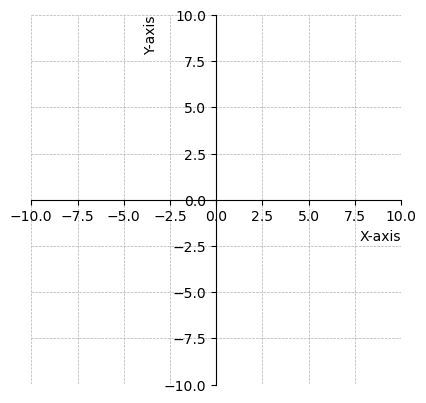

In [ ]:
import matplotlib.pyplot as plt

# 创建一个图形和坐标轴
fig, ax = plt.subplots()

# 设置坐标轴范围从0到10
ax.set_xlim(-7.5, 7.5)
ax.set_ylim(-10, 10)

# 设置坐标轴在原点(0,0)处相交
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

# 添加坐标轴标签
ax.set_xlabel('X-axis', loc='right')
ax.set_ylabel('Y-axis', loc='top')

# 添加网格线以方便观察
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# 在这里添加你的点。例如，要添加一个点 (5, 5)，你可以使用：
# ax.plot(5, 5, marker='o', label='Point at (5, 5)')
# 如果有多个点，你可以使用列表：
# x_values = [1, 2, 8]
# y_values = [3, 7, 5]
# ax.plot(x_values, y_values, marker='o', linestyle='None', label='My Points')

# 将长宽比设置为相等，以确保X轴和Y轴的比例相同
ax.set_aspect('equal', adjustable='box')

# 如果添加了点，取消注释下一行以显示图例
# ax.legend()

# 保存图表
plt.savefig('coordinate_plane.png')

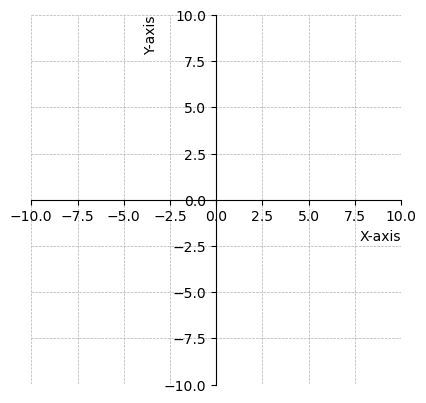

In [ ]:
import matplotlib.pyplot as plt

# 创建一个图形和坐标轴
fig, ax = plt.subplots()

# 设置坐标轴范围从0到10
ax.set_xlim(-7.5, 7.5)
ax.set_ylim(-10, 10)

# 设置坐标轴在原点(0,0)处相交
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

# 添加坐标轴标签
ax.set_xlabel('X-axis', loc='right')
ax.set_ylabel('Y-axis', loc='top')

# 添加网格线以方便观察
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# 在这里添加你的点。例如，要添加一个点 (5, 5)，你可以使用：
# ax.plot(5, 5, marker='o', label='Point at (5, 5)')
# 如果有多个点，你可以使用列表：
# x_values = [1, 2, 8]
# y_values = [3, 7, 5]
# ax.plot(x_values, y_values, marker='o', linestyle='None', label='My Points')

# 将长宽比设置为相等，以确保X轴和Y轴的比例相同
ax.set_aspect('equal', adjustable='box')

# 如果添加了点，取消注释下一行以显示图例
# ax.legend()

# 保存图表
plt.savefig('coordinate_plane.png')